In [24]:
import numpy as np
import pandas as pd
from typing import List
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os 
import tqdm
import netCDF4 as nc
from sklearn.model_selection import train_test_split
from helpers import process_h as helper
from helpers import visualize_h as vis_helper

In [2]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')
SLP_path = os.path.join(data_relative_path,'CMIP6','SLP')
GPH500_path = os.path.join(data_relative_path,'CMIP6', 'GPH500')
ERA5_path = os.path.join(data_relative_path, 'ERA5')

## Data Loading

In [3]:
chirps_dataset = nc.Dataset(f"{CHIRPS_path}/CHIRPS_Monthly_precipitation.nc")
chirps_precip_data = ((chirps_dataset['precip'][:])[9::12, 280:360, 800:920])[:30, :, :]

In [4]:
# Converting units needed for converting models precipitation measurements
unit_conversion = 86400 * 31
# Map latitude and longitude boundaries
bounds_middle_east_lat = [20, 40]
bounds_middle_east_lon = [20, 50]
boundaries_middle_east = bounds_middle_east_lon + bounds_middle_east_lat
# A dimension we want our grid to have
dim = (16, 16)
chirps_dim = chirps_precip_data.shape[1], chirps_precip_data.shape[2]

In [5]:
options = {"interpolate": True,
           "force grid": False,
           "average": False}
options_avg = {"interpolate": True,
           "force grid": False,
           "average": True}

In [10]:
precip_for_corr = helper.collect_all_datasets(precipitation_path, 'precip', chirps_dim, unit_conversion, bounds_middle_east_lat, bounds_middle_east_lon, options)
precip = {key: val[0] for key, val in precip_for_corr.items()}
masked_precip = {key: np.ma.array(val, mask=chirps_precip_data.mask) for key, val in precip.items()}

  0%|                                                                                                   | 0/24 [00:00<?, ?it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(30, 16, 16)


  4%|███▊                                                                                       | 1/24 [00:00<00:05,  3.90it/s]

pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
(30, 18, 27)


  8%|███████▌                                                                                   | 2/24 [00:00<00:05,  3.83it/s]

pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
(30, 7, 10)


 12%|███████████▍                                                                               | 3/24 [00:00<00:05,  4.06it/s]

pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
(30, 21, 25)


 17%|███████████████▏                                                                           | 4/24 [00:01<00:05,  3.84it/s]

pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc
(30, 40, 61)


 21%|██████████████████▉                                                                        | 5/24 [00:01<00:05,  3.26it/s]

pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc
(30, 20, 30)


 25%|██████████████████████▊                                                                    | 6/24 [00:01<00:05,  3.38it/s]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc
(30, 28, 43)


 29%|██████████████████████████▌                                                                | 7/24 [00:02<00:05,  3.30it/s]

pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc
(30, 20, 24)


 33%|██████████████████████████████▎                                                            | 8/24 [00:02<00:04,  3.39it/s]

pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc
(30, 21, 25)


 38%|██████████████████████████████████▏                                                        | 9/24 [00:02<00:04,  3.46it/s]

pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc
(30, 20, 24)


 42%|█████████████████████████████████████▌                                                    | 10/24 [00:02<00:03,  3.56it/s]

pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
(30, 10, 12)


 46%|█████████████████████████████████████████▎                                                | 11/24 [00:03<00:03,  3.65it/s]

pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
(30, 16, 16)


 50%|█████████████████████████████████████████████                                             | 12/24 [00:03<00:03,  3.74it/s]

pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc
(30, 10, 16)


 54%|████████████████████████████████████████████████▊                                         | 13/24 [00:03<00:02,  3.79it/s]

pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
(30, 14, 16)


 58%|████████████████████████████████████████████████████▌                                     | 14/24 [00:03<00:02,  3.82it/s]

pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc
(30, 16, 13)


 62%|████████████████████████████████████████████████████████▎                                 | 15/24 [00:04<00:02,  3.89it/s]

pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc
(30, 9, 8)


 67%|████████████████████████████████████████████████████████████                              | 16/24 [00:04<00:02,  3.92it/s]

pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
(30, 15, 21)


 71%|███████████████████████████████████████████████████████████████▊                          | 17/24 [00:04<00:01,  3.87it/s]

pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
(30, 22, 32)


 75%|███████████████████████████████████████████████████████████████████▌                      | 18/24 [00:04<00:01,  3.77it/s]

pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc
(30, 18, 27)


 79%|███████████████████████████████████████████████████████████████████████▎                  | 19/24 [00:05<00:01,  3.74it/s]

pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc
(30, 10, 16)


 83%|███████████████████████████████████████████████████████████████████████████               | 20/24 [00:05<00:01,  3.83it/s]

pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(30, 21, 25)


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 21/24 [00:05<00:00,  3.83it/s]

pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
(30, 21, 25)


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 22/24 [00:05<00:00,  3.83it/s]

pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc
(30, 21, 25)


 96%|██████████████████████████████████████████████████████████████████████████████████████▎   | 23/24 [00:06<00:00,  3.76it/s]

pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc
(30, 16, 16)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.70it/s]


In [48]:
precip_avg = helper.collect_all_datasets(precipitation_path, 'precip', chirps_dim, unit_conversion, bounds_middle_east_lat, bounds_middle_east_lon, options_avg)
precip_avg= {key: val[0] for key, val in precip_avg.items()}

 21%|██████████████████▉                                                                        | 5/24 [00:00<00:00, 25.27it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(16, 16)
pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
(18, 27)
pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
(7, 10)
pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
(21, 25)
pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc
(40, 61)
pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc
(20, 30)


 62%|████████████████████████████████████████████████████████▎                                 | 15/24 [00:00<00:00, 37.95it/s]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc
(28, 43)
pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc
(20, 24)
pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc
(21, 25)
pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc
(20, 24)
pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
(10, 12)
pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
(16, 16)
pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc
(10, 16)
pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
(14, 16)
pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc
(16, 13)
pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc


 83%|███████████████████████████████████████████████████████████████████████████               | 20/24 [00:00<00:00, 39.46it/s]

(9, 8)
pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
(15, 21)
pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
(22, 32)
pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc
(18, 27)
pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc
(10, 16)
pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(21, 25)
pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
(21, 25)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.06it/s]

pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc
(21, 25)
pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc
(16, 16)


In [49]:
dmi_baseline = scipy.io.loadmat(f"{data_relative_path}/DMI/DMI.mat")['DMI_Oct_1981_2022'][:, 1][:30]

In [50]:
wtio = helper.collect_all_datasets(WTIO_path, 'wtio')
seio = helper.collect_all_datasets(SEIO_path, 'seio')
dmi = helper.calc_dmi(wtio, seio, 'anomaly grid - mean first')

100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 129.29it/s]


tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
tos_Omon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
tos_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
tos_Omon_CNRM-CM6-1-HR_historical_r1i1p1f2_gn_19811016-20101016_v20191021.nc
tos_Omon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190826.nc
tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_19811016-20101016_v20200624.nc
tos_Omon_FGOALS-f3-L_historical_r1i1p1f1_gn_19811016-20101016_v20191007.nc
tos_Omon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191122.nc
tos_Omon_GFDL-ESM4_historical_r1i1p1f1_gr_19811016-20101016_v20190726.nc
tos_Omon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
tos_Omon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20200915.nc
tos_Omon_INM-CM5-0_

  0%|                                                                                                   | 0/24 [00:00<?, ?it/s]

tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
tos_Omon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc


100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 164.07it/s]


tos_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
tos_Omon_CNRM-CM6-1-HR_historical_r1i1p1f2_gn_19811016-20101016_v20191021.nc
tos_Omon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190826.nc
tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_19811016-20101016_v20200624.nc
tos_Omon_FGOALS-f3-L_historical_r1i1p1f1_gn_19811016-20101016_v20191007.nc
tos_Omon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191122.nc
tos_Omon_GFDL-ESM4_historical_r1i1p1f1_gr_19811016-20101016_v20190726.nc
tos_Omon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
tos_Omon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20200915.nc
tos_Omon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
tos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_19811016-20101016_v20180803.nc
tos_Omon_MCM-UA-1-0_historical_r0i0p0f2_gn_19811017-20101017_v20190731.nc
tos_Omon_MIROC6_histo

  0%|                                                                                                   | 0/24 [00:00<?, ?it/s]/mnt/c/Users/user/Documents/University/Year_3/Final Project/sub-seasonal-cmip-analysis/src/helpers/process_h.py:259: RuntimeWarning: Mean of empty slice
  wtio_climatology = np.nanmean(wtio_model, axis=0)
/mnt/c/Users/user/Documents/University/Year_3/Final Project/sub-seasonal-cmip-analysis/src/helpers/process_h.py:260: RuntimeWarning: Mean of empty slice
  seio_climatology = np.nanmean(seio_model, axis=0)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 270.73it/s]


In [51]:
corrs = dict()
for key in tqdm.tqdm(masked_precip.keys()):
    corr_mat = helper.calc_dmi_precp_corr_vec(dmi[key], masked_precip[key])
    corrs[key] = corr_mat
corr_baseline = helper.calc_dmi_precp_corr_vec(dmi_baseline, chirps_precip_data)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 97.15it/s]


In [52]:
alpha = 0.05
tested_corrs = {key: np.where(helper.calc_corr_t_test(corr_map) > alpha, 0, corr_map) for key, corr_map in corrs.items()}
tested_corr_baseline = np.where(helper.calc_corr_t_test(corr_baseline) > alpha, 0, corr_baseline)

Create a X Design matrix when each row is a grid point and each feature is a model.

In [53]:
data_relative_path = os.path.join('..', 'Data')
cmip_models_path_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
interpulated_cmip_path = os.path.join(data_relative_path,'InterpulatedCMIP6_400X600')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')


In [54]:
def get_precipitation_models() -> list[np.ndarray]:
    """
    Retrieves and processes precipitation models from a specified directory.
    Returns:
        list[np.ndarray]: A list of NumPy arrays where each array represents the mean
                          precipitation data computed across the first axis of the input arrays.
    """
    models: list[np.ndarray] = []
    for file in os.listdir(interpulated_cmip_path):
        model_path = os.path.join(interpulated_cmip_path, file)
        model_data = np.load(model_path)
        model_mean_data = np.mean(model_data, axis=0)
        models.append(model_mean_data)
    return models


## Data Preperations

In [55]:
def flatten_chirps(chirps_precip_data):
    chirps_2D = np.mean(chirps_precip_data,axis=0)
    flat_chirps_2D= chirps_2D.reshape(-1)
    return flat_chirps_2D

In [82]:
def flatten_models_to_grid_matrix(models) -> pd.DataFrame:
    """
    Create a design matrix X where each row represents a grid point, and each column 
    (feature) represents the flattened precipitation data from a different model.

    Parameters:
    -----------
    interpolated_precip_list : List[np.ndarray]
        A list of 2D arrays (matrices) with dimensions (400, 600) representing 
        precipitation data from different models. Each matrix corresponds to a different 
        model.

    Returns:
    --------
    np.ndarray
        A 2D array (design matrix X) of shape (240000, num_models), where:
        - Each row corresponds to a specific grid point across all models.
        - Each column corresponds to the precipitation data for that grid point from 
          a particular model.
    """


    # Initialize an empty matrix to store the reshaped data
    X = pd.DataFrame()

    # Loop over each model's matrix and reshape it into a vector
    for model, data_matrix in models.items():
        temp = pd.DataFrame(data_matrix.reshape(-1), columns=[model])
        X = pd.concat([X, temp], axis=1)
    return X


In [83]:
precip_avg['ACCESS-CM2'].shape

(80, 120)

In [84]:
X_precip = flatten_models_to_grid_matrix(precip_avg)
y_precip = flatten_chirps(chirps_precip_data)
# Need to remove Null values from both, would require putting them in a df and then dropna on rows
precip_df = X_precip.copy()
precip_df["chirps"] = y_precip
precip_df = precip_df.dropna()
X_corr = flatten_models_to_grid_matrix(tested_corrs)
y_corr = tested_corr_baseline
# same, but asaf said we shouldn't bother with only correlations


In [85]:
precip_df

,ACCESS-CM2,CAMS-CSM1-0,CanESM5-CanOE,CMCC-CM2-HR4,CNRM-CM6-1-HR,E3SM-1-0,EC-Earth3-AerChem,FGOALS-f3-L,FIO-ESM-2-0,GFDL-ESM4,...,MCM-UA-1-0,MIROC6,MPI-ESM1-2-HR,MRI-ESM2-0,NESM3,NorESM2-MM,SAM0-UNICON,TaiESM1,UKESM1-0-LL,chirps
0,0.942319,0.479998,1.140655,0.660180,2.706106,1.176750,0.007037,0.451921,0.060178,0.568221,...,15.386412,1.196963,0.013848,1.112214,0.596841,0.018284,0.230899,0.031408,0.257650,0.000000e+00
1,1.030896,0.420120,1.120143,0.616831,2.168157,1.144615,0.007261,0.482080,0.056102,0.534466,...,15.109906,1.200772,0.033394,1.093325,0.594128,0.022368,0.201091,0.029774,0.284660,0.000000e+00
2,1.119473,0.360242,1.099632,0.573481,1.644705,1.112481,0.007485,0.512239,0.052027,0.500710,...,14.833400,1.204580,0.052939,1.074436,0.591416,0.026452,0.171283,0.028139,0.311670,4.302927e-05
3,1.208050,0.300364,1.079121,0.530132,1.976573,1.080346,0.008325,0.542398,0.047951,0.466955,...,14.556894,1.208389,0.072485,1.055546,0.588704,0.030535,0.141475,0.026505,0.338680,0.000000e+00
4,1.296627,0.240486,1.058609,0.486783,2.301950,1.048212,0.012241,0.572557,0.043876,0.433200,...,14.280388,1.212197,0.112312,1.036657,0.585991,0.034619,0.111667,0.024871,0.365691,1.074137e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9591,34.073127,58.971217,22.859548,62.468150,49.405016,27.745830,57.618589,40.718513,94.568915,84.763523,...,20.226058,74.458679,51.347647,30.310965,32.866714,22.337050,57.148507,106.691869,51.931830,3.552129e+01
9592,32.690535,58.798342,24.981958,60.452650,41.589271,26.405728,51.542294,37.577353,94.505708,84.693702,...,20.220303,74.330351,48.967447,27.634050,34.672814,22.718874,59.089874,105.792997,50.564148,4.604496e+01
9593,31.245781,58.625466,27.104367,58.437150,34.381061,25.065625,45.465999,34.436192,94.442500,84.623881,...,20.214548,74.202023,44.981415,24.957134,36.495647,23.100699,61.031241,104.894125,48.927082,5.373804e+01
9594,29.801028,58.452590,29.226776,56.421650,32.173967,23.725522,42.896721,31.566362,94.379292,83.928434,...,20.208792,71.513150,40.995382,22.280219,38.318480,23.482523,62.972607,103.995252,47.290017,5.516348e+01


# Split The Data randomly 

In [86]:
x_precipitation_train, x_precipitation_test, y_precipitation_train, y_precipitation_test =  train_test_split(precip_df.drop(['chirps'], axis=1), precip_df['chirps'], test_size=0.2, random_state=9)

# Trainig Linear Regression models 

In [92]:
y_precipitation_train, x_precipitation_train, baseline_train_res

(8988    34.024447
 5330     1.166393
 6220     2.529853
 2518     0.033107
 4714     0.391663
           ...    
 7422    15.728080
 539      1.166168
 8286    77.839567
 4784     1.773559
 412      0.032496
 Name: chirps, Length: 6355, dtype: float64,
       ACCESS-CM2  CAMS-CSM1-0  CanESM5-CanOE  CMCC-CM2-HR4  CNRM-CM6-1-HR  \
 8988   32.726255    49.956537      13.797663     59.954296      81.043403   
 5330   14.559335     5.111159       4.051994      8.020213      16.615312   
 6220   22.090432     6.421058       7.610443     19.448293      33.959292   
 2518    6.388229     9.573423       1.630961      6.047865      22.328081   
 4714    2.602384     2.077429       3.350926      3.854963       7.521775   
 ...          ...          ...            ...           ...            ...   
 7422   35.627873    33.287668       8.472311     32.378446      93.877266   
 539     6.952420    11.662367       1.893039      9.448684      12.326389   
 8286   54.885868    47.752843      42.98823

In [93]:
# baseline model
baseline_train_res = np.mean(x_precipitation_train, axis=1)
baseline_test_res = np.mean(x_precipitation_test, axis=1)

In [94]:
rmse_baseline_train = root_mean_squared_error(y_precipitation_train, baseline_train_res)
rmse_baseline_test = root_mean_squared_error(y_precipitation_test, baseline_test_res)
r2_baseline_train = r2_score(y_precipitation_train, baseline_train_res)
r2_baseline_test = r2_score(y_precipitation_test, baseline_test_res)
print(f"Baseline train RMSE: {rmse_baseline_train}")
print(f"Baseline test RMSE: {rmse_baseline_test}")
print(f"Baseline train R2: {r2_baseline_train}")
print(f"Baseline test R2: {r2_baseline_test}")

Baseline train RMSE: 8.144410680163302
Baseline test RMSE: 8.111157503085456
Baseline train R2: 0.8151279409607312
Baseline test R2: 0.8216916777823892


In [96]:
# Initialize models for precipitation, chirps, and correlation
naive_lr_model_precipitation = LinearRegression()

# Train the models on the training data
naive_lr_model_precipitation.fit(x_precipitation_train, y_precipitation_train)

# Predict the target values on the testing data
y_precipitation_pred_naive_lr = naive_lr_model_precipitation.predict(x_precipitation_test)

# Evaluate the model performance for precipitation
rmse_naive_lr_precipitation = root_mean_squared_error(y_precipitation_test, y_precipitation_pred_naive_lr)
r2_naive_lr_precipitation = r2_score(y_precipitation_test, y_precipitation_pred_naive_lr)

print(f"Naive Linear Regression Model - RMSE: {rmse_naive_lr_precipitation}, R2: {r2_naive_lr_precipitation}")

Naive Linear Regression Model - RMSE: 4.330998765254457, R2: 0.9491627483162609


Our next steps would be to look at SAL and use it for feature selection.

# coefficient evaluetion

In [97]:
def plot_coefficients(coefficients: np.ndarray, model_names: List[str], title: str):
    """
    Plot the coefficients of the regression model.

    Parameters:
    -----------
    coefficients : np.ndarray
        The regression coefficients for each model.
        
    model_names : List[str]
        The names or labels of the models corresponding to the coefficients.

    title : str
        Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(model_names, coefficients, color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(title)
    plt.show()

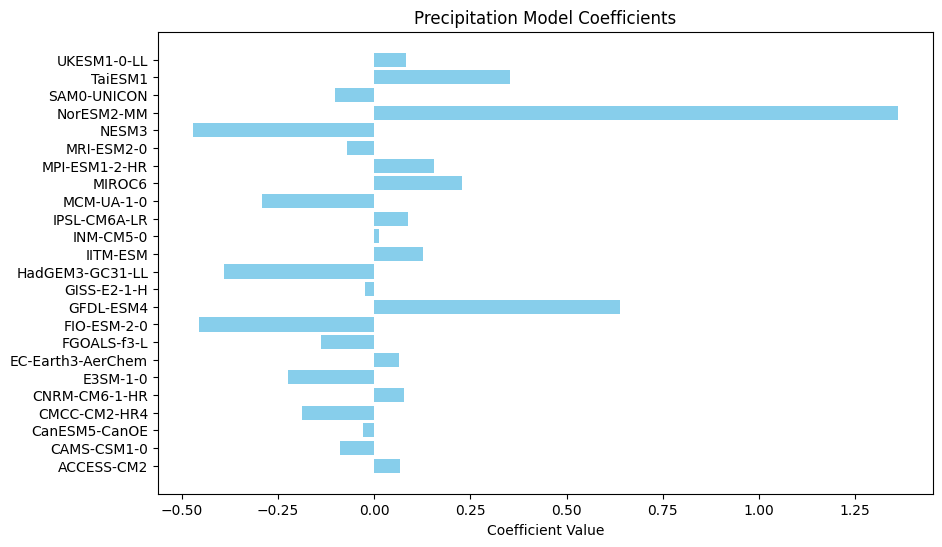

In [101]:
model_names = x_precipitation_train.columns
precipitation_coefficients = naive_lr_model_precipitation.coef_
plot_coefficients(precipitation_coefficients, model_names, 'Precipitation Model Coefficients')



In [100]:
naive_lr_model_precipitation.coef_

array([ 0.06713048, -0.08993396, -0.02910513, -0.18663478,  0.07781557,
       -0.22313641,  0.06417442, -0.13879491, -0.45482835,  0.63796468,
       -0.02388889, -0.39103614,  0.12704405,  0.01345006,  0.08693886,
       -0.29276214,  0.22737149,  0.15553842, -0.07077759, -0.47078586,
        1.36021087, -0.10196614,  0.35409513,  0.08261163])